Von Pascal Schlaak, Tim Weise - Natural Language Processing (Prof. Dr. Bantel)

# Erste Analyse gecrawlter IMDb-Filmdaten

## Module importieren

In [58]:
import json
import spacy
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer

## Daten einlesen
Wir können unseren gecrawlten, in eine Datei geschriebenen, Daten nun in ein Dictionary einlesen.

In [3]:
# Pfad zu JSON-Datei
PATH_TO_DATA = '../data/raw.json'
# Einlesen der JSON-Datei in Dictionary
data = pd.read_json(PATH_TO_DATA)

Wir erhalten folgende Rohdaten:

In [4]:
data

,title,synopsis
0,Godfellas,The film opens with three men driving in their...
1,Casino,Martin Scorsese's 1995 film Casino follows the...
2,The Lord of the Rings: The Fellowship of the Ring,"The prologue, spoken by Galadriel, shows the D..."
3,The Hobbit: An Unexpected Journey,Prologue: During the preparations for the birt...


## Tokenisierung
Für eine erste Analyse unserer Daten können wir uns einen spezifizierten Eintrag der Datei näher anschauen.

In [5]:
# Laden des Sprach-Supports für spätere Analysen wie POS-Tagging
nlp = spacy.load("en_core_web_sm")
# Tokenisieren der Zusammenfassung des Films: Godfellas
document = nlp(data['synopsis'][0])

Wir erhalten folgende Textdaten:

In [6]:
document

The film opens with three men driving in their car late at night on a highway. In the car are Henry Hill (Ray Liotta), Jimmy Conway (Robert DeNiro) and Tommy DeVito (Joe Pesci). Jimmy and Tommy are asleep when Henry hears a loud thumping noise. Trying to figure out the source of the sound, Henry suddenly realizes they need to stop and check the trunk. When they open it, we see a beaten man wrapped in several bloody tablecloths. An enraged Tommy stabs the man several times with a kitchen knife and Jimmy shoots him four times with a revolver. Henry slams the trunk lid shut and we hear a voiceover (Henry) say "As far back as I can remember, I always wanted to be a gangster." We now go back several decades, to see the events that will lead up to this scene. In the 1950s, young Henry Hill idolizes the Lucchese crime family gangsters in his blue-collar, predominantly Italian neighborhood in East New York, Brooklyn, and in 1955 quits school and goes to work for them. The local mob capo, Pauli

## POS-Tagging

Wir können nun untersuchen, ob *spaCy* eine erfolgreiche Lemmatisierung/POS-Tagging des englischen Textes ermöglicht. Hierfür nutzen wir die bereits integrierten Tags.

In [44]:
pos = [{'Text': token.text, 'Lemma': token.lemma_, 'POS tag': token.pos_, 'Shape': token.shape_, 'Alpha': token.is_alpha, 'Stop': token.is_stop, 'Entity': token.ent_type_} for token in document]
tokens = pd.DataFrame(pos)

In [45]:
tokens

,Text,Lemma,POS tag,Shape,Alpha,Stop,Entity
0,The,the,DET,Xxx,True,True,
1,film,film,NOUN,xxxx,True,False,
2,opens,open,VERB,xxxx,True,False,
3,with,with,ADP,xxxx,True,True,
4,three,three,NUM,xxxx,True,True,CARDINAL
...,...,...,...,...,...,...,...
1946,1996,1996,NUM,dddd,False,False,DATE
1947,while,while,SCONJ,xxxx,True,True,
1948,still,still,ADV,xxxx,True,True,
1949,incarcerated,incarcerate,VERB,xxxx,True,False,


Betrachten wir beispielsweise die Ausgabe des siebenten Wortes *driving*, können wir die Funktionlität von spaCy validieren. Wir erhalten *drive* als Grundform des Wortes. Es handelt sich um ein Verb, welches kein Stoppwort darstellt.

In [9]:
tokens.loc[6]

Text       driving
Lemma        drive
POS tag       VERB
Shape         xxxx
Alpha         True
Stop         False
Name: 6, dtype: object

## Token Häufigkeit (gesamt)

Wir können nun mit einer konkreten Analyse des Textes fortfahren. Hierfür Tokenisieren wir unsere Textdaten und entfernen alle Stoppwörter und Satzzeichen. Diese geben uns wenige Hinweise auf den konkreten Inhalt des Films. Wir zählen ebenfalls die Häugigkeit aller Wörter und erstellen eine Liste von (Eigen-)namen für die weitere Analyse.

In [12]:
# Alle Token in Liste speichern
words = [token.text for token in document]
# Häufigkeit für jedes Token berechnen
counters = Counter(words)

In [13]:
# Neues DataFrame erstellen
frequency = pd.DataFrame(columns=['Frequency'])
# Häufigkeit der Token zuweisen
frequency['Frequency'] = pd.Series(counters)
# Absteigend sortieren
frequency = frequency.sort_values(by=['Frequency'], ascending=False)

In [14]:
frequency

,Frequency
",",87
the,69
.,68
and,66
Henry,51
...,...
Frank,1
decades,1
murders,1
brutally,1


Die gecrawlten Zusammenfassungen verschiedener Filme sollten uns somit generell eine gute Datenbasis für weitere Analysen bieten, insofern die Länge der aktuellen Filmbeschreibung keine Ausnahme war. 

Wir können uns nun beispielsweise die 30 am häufigsten vorkommenden Wörter der Zusammenfassung plotten.

In [25]:
common_tokens = dict(Counter(words).most_common(20))

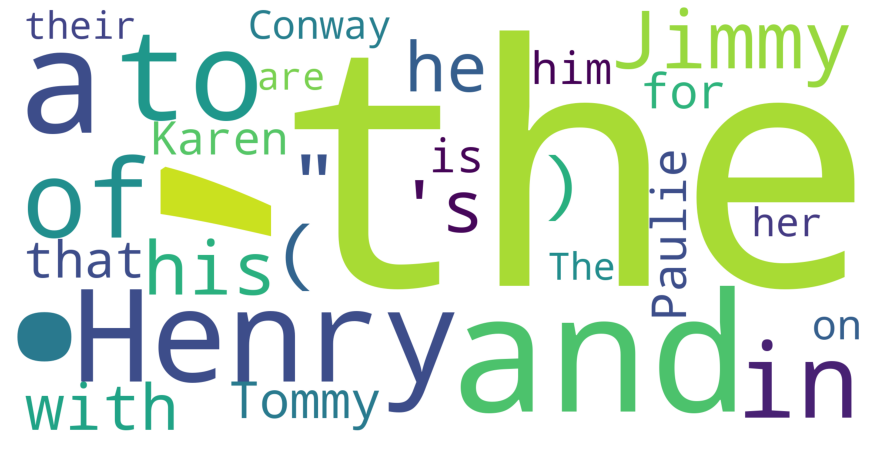

In [26]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_tokens)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Worthäufigkeit (ohne Satzzeichen und Stoppwörter)

In [27]:
# Alle Wörter in Liste speichern
words = [token.text for token in document if not token.is_stop and not token.is_punct]
# Worthäufigkeit berechnen
counters = Counter(words)

In [28]:
# Neues DataFrame erstellen
frequency = pd.DataFrame(columns=['Frequency'])
# Häufigkeit der Token zuweisen
frequency['Frequency'] = pd.Series(counters)

In [64]:
common_words = dict(Counter(words).most_common(20))

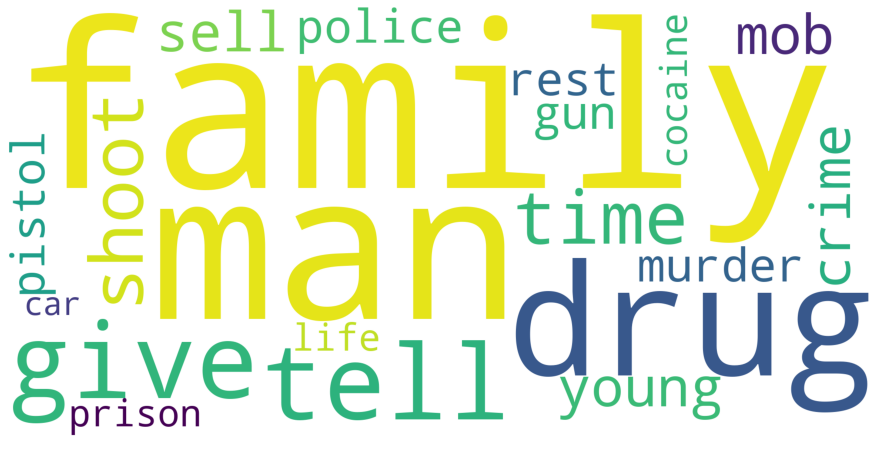

In [65]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_words)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

## Worthäufigkeit (ohne Satzzeichen, Stoppwörter und Eigennamen)

In [33]:
# Eigennamen identifizieren
entities = sorted(set([entity.text for entity in document.ents]))
# Token auf Wörter ohne Eigennamen, Stoppwörter, Satzzeichen reduzieren
words = [token.lemma_ for token in document if token.text not in entities and not token.is_stop and not token.is_punct]
# Worthäufigkeit berechnen
counters = Counter(words)

In [34]:
# Neues DataFrame erstellen
frequency = pd.DataFrame(columns=['Frequency'])
# Häufigkeit der Token zuweisen
frequency['Frequency'] = pd.Series(counters)

In [35]:
common_words = dict(Counter(words).most_common(20))

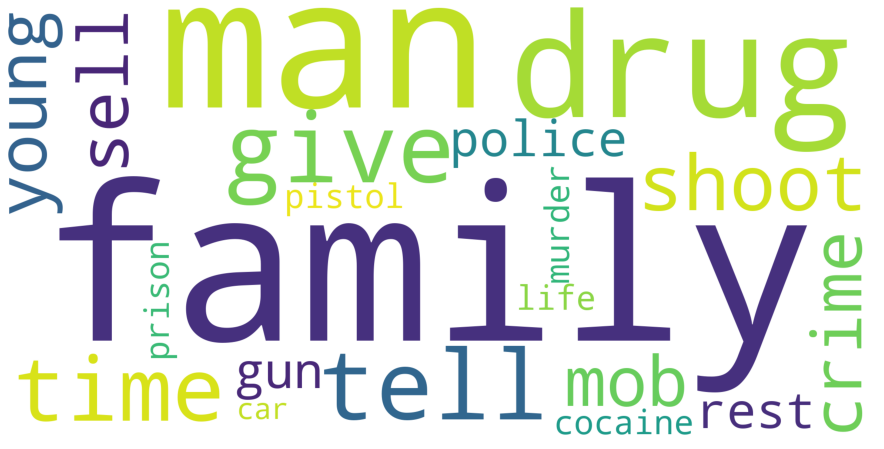

In [36]:
word_cloud = WordCloud(background_color="white", width=2000, height=1000,).generate_from_frequencies(common_words)
plt.rcParams["figure.figsize"] = (16, 8)
plt.axis("off")
plt.imshow(word_cloud)

Wir können erkennen, dass diese Zusammenfassung von Godfellas des öfteren die Namen der Rollen beinhaltet. Ebenfalls können wichtige Rückschlüsse auf die Handlung gezogen werden. Basierend auf der Zusammenfassung der Handlung scheint es sich bei Godfellas um ein gewaltvollen Krimi zu handeln, der sich ebenfalls mit Drogen, Morden, Schusswechsel und der Polizei auseinandersetzt. Interessanterweise kommt das Wort "Mafia" nicht unter den 25 am häufigsten verwendeten Wörtern vor. Wir können dennoch untersuchen, ob Mafia mindestens ein mal erwähnt wird. Hierfür suchen wir nach Mafia als Key in unserem frequencies-Dictionary in Groß- und Kleinschreibung:

In [187]:
frequencies['Mafia'] + frequencies['mafia']

1

Unsere Zusammenfassung enthält anscheinend nur ein mal das Wort Mafia. Wir können uns ebenfalls ein Set der verwendeten (Eigen-)namen ausgeben. Diese könnte uns weitere Rückschlüsse auf die Zeit der Handlung, Spielorte, Figuren, Darsteller und weitere wichtige Informationen bieten.

## Eigennamen

In [188]:
spacy.displacy.render(document, style="ent", jupyter=True)

### Personen / Rollen

In [189]:
set([token.text for token in document.ents if token.label_ == 'PERSON'])

{'Batts',
 'Billy Batts',
 "Billy Batts'",
 'De Niro',
 'Debi Mazar',
 'Frank Vincent',
 'Gina Mastrogiacomo',
 'Henry',
 'Henry Hill',
 'Janice',
 'Janice Rossi',
 'Jimmy',
 'Jimmy Burke',
 'Jimmy Conway',
 'Joe Pesci',
 'John F. Kennedy International Airport',
 'Karen',
 'Lois',
 'Lorraine Bracco',
 'Michael Imperioli',
 'Paul Sorvino',
 'Paul Vario',
 'Paulie',
 'Paulie Cicero',
 'Paulie warns Henry',
 'Ray Liotta',
 'Robert DeNiro',
 'Sandy',
 'Spider',
 'Tommy',
 'Tommy DeVito',
 'Tuddy'}

### Orte

In [190]:
set([token.text for token in document.ents if token.label_ == 'GPE'])

{'Brooklyn',
 'Conway',
 'Copacabana',
 'DeVito',
 'East New York',
 'Florida',
 'Henry',
 'Jimmy',
 'Pittsburgh',
 'Tampa',
 'Tommy'}

### Zeiten

In [191]:
set([token.text for token in document.ents if token.label_ == 'DATE'])

{'1955',
 '1988',
 '1996',
 '2004',
 'December 1978',
 'June 1970',
 'a few days',
 'four years',
 'several decades',
 'several months',
 'six months later',
 'the 1950s',
 'the years'}

Es könnte sich hierbei um eine Geschichte der irischen Mafia handeln, beginnend in den 1950er Jahren. Robert de Niro und Joe Pesci scheinen eine Rolle zu verkörpern. Spielort könnte New York sein.

## Vorverarbeitung der Daten

In [46]:
lemmas = []
for token in document:
    # Nimm lemmatisiertes Token falls kein Eigenname, Stoppwort und Satzzeichen
    if not token.ent_type_ and not token.is_stop and not token.is_punct:
        lemmas.append(token.lemma_)
bag_of_words = ' '.join(lemmas)

In [47]:
bag_of_words

'film open man drive car highway car asleep hear loud thump noise try figure source sound suddenly realize need stop check trunk open beat man wrap bloody tablecloth enraged stab man time kitchen knife shoot time revolver slam trunk lid shut hear voiceover far remember want gangster event lead scene young idolize crime family gangster blue collar predominantly neighborhood quit school go work local mob capo base actual mobster close associate base help cultivate criminal career team young sell carton cigarette give employee local factory cross guard cop sell detective confiscate money load arrest slink away tell brother go court give slap wrist give substantial reward silence call graduation gift tell despite get pinch reveal name police learn important thing line work rat friend mouth shut rest gang greet joyful acceptance adult conspire steal cargo pass help key heist steal cargo terminal robbery help gain trust give sizable cut haul half irish know man fledged member crime family fr

# Bag of Words

* TODO: Entities noch drin!

In [51]:
# Matrix von Token mit Frequenz plus Normalisieren mittels "Inverse-document-frequency" (IDF)
vectorizer = TfidfVectorizer()
# Lernen des Vokabulars und IDF
X = vectorizer.fit_transform([bag_of_words])

In [52]:
X.shape

(1, 440)

In [60]:
X.toarray()

array([[0.05534245, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.02767123, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.05534245, 0.08301368, 0.05534245, 0.02767123, 0.05534245,
        0.02767123, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.02767123, 0.02767123, 0.05534245, 0.02767123, 0.05534245,
        0.05534245, 0.05534245, 0.02767123, 0.02767123, 0.05534245,
        0.02767123, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.02767123, 0.08301368, 0.02767123, 0.02767123, 0.02767123,
        0.05534245, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.02767123, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.08301368, 0.05534245, 0.08301368, 0.08301368, 0.02767123,
        0.02767123, 0.02767123, 0.02767123, 0.02767123, 0.02767123,
        0.02767123, 0.02767123, 0.02767123, 0.02767123, 0.05534245,
        0.02767123, 0.02767123, 0.11068491, 0.05534245, 0.02767123,
        0.02767123, 0.02767123, 0.02767123, 0.02

In [63]:
np.max(X.toarray())

0.27671226645624275

In [55]:
vectorizer.get_feature_names()

['abandon',
 'accept',
 'acceptance',
 'actual',
 'admit',
 'adult',
 'afloat',
 'aid',
 'angry',
 'anonymity',
 'apartment',
 'arrest',
 'ask',
 'asleep',
 'associate',
 'attention',
 'authority',
 'average',
 'avoid',
 'away',
 'babysitter',
 'back',
 'bad',
 'badly',
 'bail',
 'base',
 'beat',
 'begin',
 'behavior',
 'bloody',
 'blue',
 'body',
 'book',
 'boss',
 'boyfriend',
 'break',
 'bring',
 'brother',
 'brutally',
 'burke',
 'bury',
 'business',
 'bust',
 'cache',
 'cage',
 'call',
 'callously',
 'camera',
 'cancer',
 'capo',
 'car',
 'card',
 'career',
 'cargo',
 'carry',
 'carton',
 'catch',
 'chastise',
 'check',
 'chest',
 'child',
 'chore',
 'cigarette',
 'clear',
 'close',
 'club',
 'clueless',
 'cocaine',
 'coke',
 'coldly',
 'collar',
 'collateral',
 'collide',
 'compatriot',
 'compete',
 'completely',
 'complicated',
 'confiscate',
 'confront',
 'connection',
 'consider',
 'conspire',
 'continuous',
 'convince',
 'convinced',
 'convincing',
 'cook',
 'coordinate',
 'c

## Fazit
Eine erste Analyse einer gecrawlten IMDb-Zusammenfassung des Filmes Godfellas mit Python und spaCy liefert einen vielversprechenden Ansatz, welcher im Folgenden weiter verfolgt wird. Im nächten Schritt soll eine Analyse aller Einträge des Crawlings untersucht werden. Hierbei ist es wichtig mit der Verarbeitung vieler Daten zu beschäftigen.